# Harmonize annotations for the RBC-GEM

## Setup
### Import packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from rbc_gem_utils import (
    COBRA_CONFIGURATION,
    ROOT_PATH,
    ANNOTATION_PATH,
    MODEL_PATH,
    INTERIM_PATH,
    read_rbc_model,
    compare_tables,
    visualize_comparison,
    split_string,
)

from rbc_gem_utils.database import (
    HUMANGEM_DB_TAG,
    UNIPROT_DB_TAG,
    MIM_DB_TAG,
    TCDB_DB_TAG,
    DRUGBANK_DB_TAG,
    DRUGCENTRAL_DB_TAG,
    CDCDB_DB_TAG,
)

### Define configuration
#### COBRA Configuration

In [2]:
COBRA_CONFIGURATION

Attribute,Description,Value
solver,Mathematical optimization solver,glpk
tolerance,"General solver tolerance (feasibility, integrality, etc.)",1e-07
lower_bound,Default reaction lower bound,-1000.0
upper_bound,Default reaction upper bound,1000.0
processes,Number of parallel processes,15
cache_directory,Path for the model cache,/Users/zhaiman/Library/Caches/cobrapy
max_cache_size,Maximum cache size in bytes,104857600
cache_expiration,Model cache expiration time in seconds (if any),None


## Load RBC-GEM model

In [3]:
model = read_rbc_model(filetype="xml")
model.reactions.sort()
model.genes.sort()
model.metabolites.sort()
model

Name,RBC_GEM
Memory address,10d6a0b90
Number of metabolites,1971
Number of reactions,2798
Number of genes,656
Number of groups,75
Objective expression,1.0*NaKt - 1.0*NaKt_reverse_db47e
Compartments,"cytosol, extracellular space"


## Create annotation tables

In [4]:
annotation_dirpath = f"{ROOT_PATH}{ANNOTATION_PATH}"
compare = True
display_nunique = True
overwrite = True

preserve_model_previous = True
model_annotation_dfs = {
    "reactions": None,
    "metabolites": None,
    "genes": None,
}
to_double_check = {
    "reactions": {},
    "metabolites": {},
    "genes": {},
}

### Reactions

In [5]:
annotation_type = "reactions"
databases = [HUMANGEM_DB_TAG, "References"]
df_annotations_all = pd.read_csv(
    f"{ROOT_PATH}{MODEL_PATH}/{annotation_type}.tsv",
    sep="\t",
    index_col=0,
    dtype=str,
)
df_annotations_all = df_annotations_all.set_index(annotation_type)
df_annotations_all = df_annotations_all.rename(
    {c: f"{c}_MODEL" for c in df_annotations_all.columns}, axis=1
)

for db_tag in databases:
    df = pd.read_csv(
        f"{annotation_dirpath}/{annotation_type}_{db_tag}.tsv",
        sep="\t",
        index_col=0,
        dtype=str,
    ).set_index(annotation_type)
    df.columns = [f"{c}_{db_tag}" for c in df.columns]
    df_annotations_all = df_annotations_all.merge(
        df,
        left_index=True,
        right_index=True,
        how="left",
    )

# Keep database tags on duplicate columns for reconcilliation, remove for unique columns
unique_columns = set([name.rsplit("_", 1)[0] for name in df_annotations_all.columns])
to_double_check[annotation_type] = {
    unique: [
        name for name in df_annotations_all.columns if name.rsplit("_", 1)[0] == unique
    ]
    for unique in unique_columns
}
unique_mapping = {
    to_double_check[annotation_type].pop(unique).pop(): unique
    for unique, dbs in to_double_check[annotation_type].copy().items()
    if len(dbs) == 1
}
print(f"Annotation columns to reconcile: {to_double_check[annotation_type]}")
df_annotations_all

Annotation columns to reconcile: {'reactome': ['reactome_MODEL', 'reactome_MetAtlas'], 'metanetx.reaction': ['metanetx.reaction_MODEL', 'metanetx.reaction_MetAtlas'], 'spontaneous': ['spontaneous_MODEL', 'spontaneous_MetAtlas', 'spontaneous_References'], 'ec-code': ['ec-code_MODEL', 'ec-code_MetAtlas'], 'references': ['references_MODEL', 'references_References'], 'bigg.reaction': ['bigg.reaction_MODEL', 'bigg.reaction_MetAtlas'], 'rhea': ['rhea_MODEL', 'rhea_MetAtlas'], 'metatlas': ['metatlas_MODEL', 'metatlas_MetAtlas'], 'tcdb': ['tcdb_MODEL', 'tcdb_MetAtlas'], 'kegg.reaction': ['kegg.reaction_MODEL', 'kegg.reaction_MetAtlas'], 'vmhreaction': ['vmhreaction_MODEL', 'vmhreaction_MetAtlas']}


,biocyc_MODEL,sabiork.reaction_MODEL,sbo_MODEL,seed.reaction_MODEL,metanetx.reaction_MODEL,kegg.reaction_MODEL,vmhreaction_MODEL,metatlas_MODEL,reactome_MODEL,tcdb_MODEL,...,bigg.reaction_MetAtlas,reactome_MetAtlas,vmhreaction_MetAtlas,metanetx.reaction_MetAtlas,tcdb_MetAtlas,rhea_MetAtlas,spontaneous_MetAtlas,ec-code_MetAtlas,spontaneous_References,references_References
reactions,,,,,,,,,,,,,,,,,,,,,
13DAMPPOX,NaN,NaN,NaN,NaN,MNXR94687,NaN,13DAMPPOX,MAR07992,NaN,NaN,...,13DAMPPOX,NaN,13DAMPPOX,MNXR94687,NaN,NaN,0,1.4.3.6;1.4.3.21;1.4.3.22,0,pubmed:23330127
15KPGE1Ry,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,pubmed:236730;pubmed:24657656;pubmed:6597453;p...
15KPGE2Ry,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,pubmed:236730;pubmed:24657656;pubmed:6597453;p...
15KPGE3Ry,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,pubmed:236730;pubmed:24657656;pubmed:6597453;p...
15KPGF1Ry,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,pubmed:236730;pubmed:24657656;pubmed:6597453;p...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XYLt,NaN,NaN,NaN,NaN,MNXR105270,NaN,XYLt,MAR08867,NaN,NaN,...,XYLt,NaN,XYLt,MNXR105270,NaN,NaN,0,NaN,0,pubmed:23506862;pubmed:4487965;pubmed:5084118
YYDPP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
YYYTPAP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,pubmed:6058286;pubmed:7002549


#### Reconcile cross-referenced from multiple sources
These columns had multiple mappings and need to be reconciled.

In [6]:
reconcilliation = {
    # Overwrite with MetAtlas
    "metanetx.reaction": HUMANGEM_DB_TAG,
    "kegg.reaction": HUMANGEM_DB_TAG,
    "vmhreaction": HUMANGEM_DB_TAG,
    "metatlas": HUMANGEM_DB_TAG,
    "reactome": HUMANGEM_DB_TAG,
    "tcdb": HUMANGEM_DB_TAG,
    "ec-code": HUMANGEM_DB_TAG,
    "rhea": HUMANGEM_DB_TAG,
    # Preserve from model, some BiGG mappings in MetAtlas are off.
    "bigg.reaction": "MODEL",
    # Non-miriam fields, spontaneous comes from References
    "spontaneous": "References",
    "references": "References",
}

df_annotations = df_annotations_all.copy()
for key, chosen_col in reconcilliation.items():
    if key not in to_double_check[annotation_type]:
        continue
    df_base_column = df_annotations_all.loc[:, f"{key}_{chosen_col}"].copy()
    df_base_column.name = key
    df_columns = df_annotations_all.loc[:, to_double_check[annotation_type][key]]
    for idx, row in df_columns.iterrows():
        if preserve_model_previous:
            # Preserve old ID to prevent loss of ID
            try:
                if not row.isna()[f"{key}_MODEL"] and row.isna()[f"{key}_{chosen_col}"]:
                    df_base_column[idx] = row[f"{key}_MODEL"]
            except KeyError as e:
                pass

    df_annotations = df_annotations.drop(to_double_check[annotation_type][key], axis=1)
    to_double_check[annotation_type].pop(key)
    df_annotations[key] = df_base_column


# Overwrite
df_annotations = df_annotations.rename(unique_mapping, axis=1)
df_annotations = df_annotations.reset_index(drop=False)
model_annotation_dfs[annotation_type] = df_annotations
df_annotations

,reactions,biocyc,sabiork.reaction,sbo,seed.reaction,metanetx.reaction,kegg.reaction,vmhreaction,metatlas,reactome,tcdb,ec-code,rhea,bigg.reaction,spontaneous,references
0,13DAMPPOX,NaN,NaN,NaN,NaN,MNXR94687,NaN,13DAMPPOX,MAR07992,NaN,NaN,1.4.3.6;1.4.3.21;1.4.3.22,NaN,13DAMPPOX,0,pubmed:23330127
1,15KPGE1Ry,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,pubmed:236730;pubmed:24657656;pubmed:6597453;p...
2,15KPGE2Ry,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,pubmed:236730;pubmed:24657656;pubmed:6597453;p...
3,15KPGE3Ry,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,pubmed:236730;pubmed:24657656;pubmed:6597453;p...
4,15KPGF1Ry,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,pubmed:236730;pubmed:24657656;pubmed:6597453;p...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2793,XYLt,NaN,NaN,NaN,NaN,MNXR105270,NaN,XYLt,MAR08867,NaN,NaN,NaN,NaN,XYLt,0,pubmed:23506862;pubmed:4487965;pubmed:5084118
2794,YYDPP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
2795,YYYTPAP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,pubmed:6058286;pubmed:7002549
2796,ZN2Htex2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,pubmed:11817695;pubmed:18936201;pubmed:33996761


#### Save annotations

reactions: 2798
biocyc: 188
sabiork.reaction: 149
sbo: 3
seed.reaction: 288
metanetx.reaction: 1009
kegg.reaction: 509
vmhreaction: 1433
metatlas: 1411
reactome: 243
tcdb: 28
ec-code: 384
rhea: 497
bigg.reaction: 1307
spontaneous: 2
references: 887


,reactions,biocyc,sabiork.reaction,sbo,seed.reaction,metanetx.reaction,kegg.reaction,vmhreaction,metatlas,reactome,tcdb,ec-code,rhea,bigg.reaction,spontaneous,references
0,13DAMPPOX,NaN,NaN,NaN,NaN,MNXR94687,NaN,13DAMPPOX,MAR07992,NaN,NaN,1.4.3.6;1.4.3.21;1.4.3.22,NaN,13DAMPPOX,0,pubmed:23330127
1,15KPGE1Ry,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,pubmed:236730;pubmed:24657656;pubmed:6597453;p...
2,15KPGE2Ry,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,pubmed:236730;pubmed:24657656;pubmed:6597453;p...
3,15KPGE3Ry,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,pubmed:236730;pubmed:24657656;pubmed:6597453;p...
4,15KPGF1Ry,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,pubmed:236730;pubmed:24657656;pubmed:6597453;p...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2793,XYLt,NaN,NaN,NaN,NaN,MNXR105270,NaN,XYLt,MAR08867,NaN,NaN,NaN,NaN,XYLt,0,pubmed:23506862;pubmed:4487965;pubmed:5084118
2794,YYDPP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
2795,YYYTPAP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,pubmed:6058286;pubmed:7002549
2796,ZN2Htex2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,pubmed:11817695;pubmed:18936201;pubmed:33996761


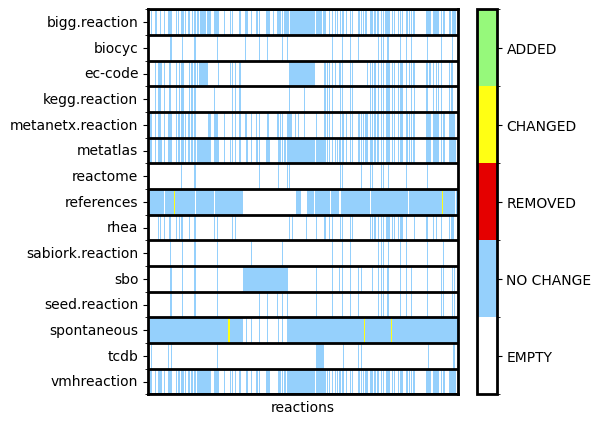

In [7]:
assert (
    len(to_double_check[annotation_type]) == 0
), f"There are still columns with data that need reconcilliation: {to_double_check[annotation_type]}"
df_annotations = model_annotation_dfs[annotation_type]

if compare:
    try:
        df_previous = pd.read_csv(
            f"{ROOT_PATH}{MODEL_PATH}/{annotation_type}.tsv",
            sep="\t",
            index_col=0,
            dtype=str,
        )
    except FileNotFoundError:
        df_previous = pd.DataFrame([], columns=[annotation_type])

    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    df_comparision = compare_tables(
        df_previous.set_index(annotation_type),
        df_annotations.set_index(annotation_type),
    )
    ax = visualize_comparison(df_comparision)

if display_nunique:
    for col in df_annotations.columns:
        df = (
            df_annotations[col]
            .apply(lambda x: split_string(x))
            .explode(col)
            .drop_duplicates()
        )
        print(f"{df.name}: {df.nunique()}")


if overwrite:
    df_annotations.to_csv(f"{ROOT_PATH}{MODEL_PATH}/{annotation_type}.tsv", sep="\t")
else:
    df_annotations.to_csv(f"{ROOT_PATH}{INTERIM_PATH}/{annotation_type}.tsv", sep="\t")
df_annotations

### Metabolites

In [8]:
annotation_type = "metabolites"
databases = [HUMANGEM_DB_TAG]
df_annotations_all = pd.read_csv(
    f"{ROOT_PATH}{MODEL_PATH}/{annotation_type}.tsv",
    sep="\t",
    index_col=0,
    dtype=str,
)
df_annotations_all = df_annotations_all.set_index(annotation_type)
df_annotations_all = df_annotations_all.rename(
    {c: f"{c}_MODEL" for c in df_annotations_all.columns}, axis=1
)

for db_tag in databases:
    df = pd.read_csv(
        f"{annotation_dirpath}/{annotation_type}_{db_tag}.tsv",
        sep="\t",
        index_col=0,
        dtype=str,
    ).set_index(annotation_type)
    df.columns = [f"{c}_{db_tag}" for c in df.columns]
    df_annotations_all = df_annotations_all.merge(
        df,
        left_index=True,
        right_index=True,
        how="left",
    )

# Keep database tags on duplicate columns for reconcilliation, remove for unique columns
unique_columns = set([name.rsplit("_", 1)[0] for name in df_annotations_all.columns])
to_double_check[annotation_type] = {
    unique: [
        name for name in df_annotations_all.columns if name.rsplit("_", 1)[0] == unique
    ]
    for unique in unique_columns
}
unique_mapping = {
    to_double_check[annotation_type].pop(unique).pop(): unique
    for unique, dbs in to_double_check[annotation_type].copy().items()
    if len(dbs) == 1
}
print(f"Annotation columns to reconcile: {to_double_check[annotation_type]}")
df_annotations_all

Annotation columns to reconcile: {'lipidmaps': ['lipidmaps_MODEL', 'lipidmaps_MetAtlas'], 'pubchem.compound': ['pubchem.compound_MODEL', 'pubchem.compound_MetAtlas'], 'bigg.metabolite': ['bigg.metabolite_MODEL', 'bigg.metabolite_MetAtlas'], 'vmhmetabolite': ['vmhmetabolite_MODEL', 'vmhmetabolite_MetAtlas'], 'chebi': ['chebi_MODEL', 'chebi_MetAtlas'], 'metatlas': ['metatlas_MODEL', 'metatlas_MetAtlas'], 'metanetx.chemical': ['metanetx.chemical_MODEL', 'metanetx.chemical_MetAtlas'], 'hmdb': ['hmdb_MODEL', 'hmdb_MetAtlas'], 'kegg.compound': ['kegg.compound_MODEL', 'kegg.compound_MetAtlas']}


,biocyc_MODEL,envipath_MODEL,inchikey_MODEL,kegg.drug_MODEL,kegg.glycan_MODEL,reactome_MODEL,sabiork.compound_MODEL,sbo_MODEL,seed.compound_MODEL,slm_MODEL,...,bigg.metabolite_MODEL,metatlas_MetAtlas,bigg.metabolite_MetAtlas,kegg.compound_MetAtlas,hmdb_MetAtlas,chebi_MetAtlas,pubchem.compound_MetAtlas,lipidmaps_MetAtlas,vmhmetabolite_MetAtlas,metanetx.chemical_MetAtlas
metabolites,,,,,,,,,,,,,,,,,,,,,
10fthf_c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10fthf,MAM00266c,10fthf,C00234,NaN,CHEBI:15637,122347,NaN,10fthf,MNXM237
12ppd__R_c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12ppd__R,MAM02771c,12ppd__R,C00583,HMDB0001881,CHEBI:16997,1030,NaN,12ppd_R,MNXM1118;MNXM1255;MNXM90191
12ppd__S_c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12ppd__S,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13dampp_c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,13dampp,MAM00248c,13dampp,C00986,HMDB0000002,CHEBI:15725,428,NaN,13dampp,MNXM146468;MNXM350
13dpg_c,META:DPG,NaN,LJQLQCAXBUHEAZ-UWTATZPHSA-J,NaN,NaN,29800,21215,SBO:0000247,cpd00203,NaN,...,13dpg,MAM00247c,13dpg,C00236,NaN,CHEBI:16001,439191,NaN,13dpg,MNXM261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zn2_c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,zn2,MAM03157c,NaN,C00038,HMDB0015532,CHEBI:29105,32051,NaN,zn2,MNXM149
zn2_e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,zn2,MAM03157e,NaN,C00038,HMDB0015532,CHEBI:29105,32051,NaN,zn2,MNXM149
ztp_c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Reconcile cross-referenced from multiple sources
These columns had multiple mappings and need to be reconciled.

In [9]:
reconcilliation = {
    # Overwrite with MetAtlas
    "kegg.compound": HUMANGEM_DB_TAG,
    "lipidmaps": HUMANGEM_DB_TAG,
    "hmdb": HUMANGEM_DB_TAG,
    "vmhmetabolite": HUMANGEM_DB_TAG,
    "metatlas": HUMANGEM_DB_TAG,
    "chebi": HUMANGEM_DB_TAG,
    "pubchem.compound": HUMANGEM_DB_TAG,
    "metanetx.chemical": HUMANGEM_DB_TAG,
    # Preserve from model, some BiGG mappings in MetAtlas are off.
    "bigg.metabolite": "MODEL",
    # # Non-miriam fields
    # 'references': 'References',
}

df_annotations = df_annotations_all.copy()
for key, chosen_col in reconcilliation.items():
    if key not in to_double_check[annotation_type]:
        continue
    df_base_column = df_annotations_all.loc[:, f"{key}_{chosen_col}"].copy()
    df_base_column.name = key

    df_columns = df_annotations_all.loc[:, to_double_check[annotation_type][key]]
    for idx, row in df_columns.iterrows():
        if preserve_model_previous:
            # Preserve old ID to prevent loss of ID
            try:
                if not row.isna()[f"{key}_MODEL"] and row.isna()[f"{key}_{chosen_col}"]:
                    df_base_column[idx] = row[f"{key}_MODEL"]
            except KeyError as e:
                pass

    df_annotations[key] = df_base_column
    df_annotations = df_annotations.drop(to_double_check[annotation_type][key], axis=1)
    to_double_check[annotation_type].pop(key)

# Overwrite
df_annotations = df_annotations.rename(unique_mapping, axis=1)
df_annotations = df_annotations.reset_index(drop=False)
model_annotation_dfs[annotation_type] = df_annotations
df_annotations

,metabolites,biocyc,envipath,inchikey,kegg.drug,kegg.glycan,reactome,sabiork.compound,sbo,seed.compound,slm,kegg.compound,lipidmaps,hmdb,vmhmetabolite,metatlas,chebi,pubchem.compound,metanetx.chemical,bigg.metabolite
0,10fthf_c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C00234,NaN,NaN,10fthf,MAM00266c,CHEBI:15637,122347,MNXM237,10fthf
1,12ppd__R_c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C00583,NaN,HMDB0001881,12ppd_R,MAM02771c,CHEBI:16997,1030,MNXM1118;MNXM1255;MNXM90191,12ppd__R
2,12ppd__S_c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12ppd__S
3,13dampp_c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C00986,NaN,HMDB0000002,13dampp,MAM00248c,CHEBI:15725,428,MNXM146468;MNXM350,13dampp
4,13dpg_c,META:DPG,NaN,LJQLQCAXBUHEAZ-UWTATZPHSA-J,NaN,NaN,29800,21215,SBO:0000247,cpd00203,NaN,C00236,NaN,HMDB62758,13dpg,MAM00247c,CHEBI:16001,439191,MNXM261,13dpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1966,zn2_c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C00038,NaN,HMDB0015532,zn2,MAM03157c,CHEBI:29105,32051,MNXM149,zn2
1967,zn2_e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C00038,NaN,HMDB0015532,zn2,MAM03157e,CHEBI:29105,32051,MNXM149,zn2
1968,ztp_c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1969,zymst_c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C05437,LMST01010066,NaN,zymst,MAM03158c,CHEBI:18252,92746,MNXM574,zymst


#### Save annotations

metabolites: 1971
biocyc: 212
envipath: 72
inchikey: 184
kegg.drug: 64
kegg.glycan: 6
reactome: 455
sabiork.compound: 218
sbo: 1
seed.compound: 224
slm: 7
kegg.compound: 765
lipidmaps: 227
hmdb: 501
vmhmetabolite: 1142
metatlas: 1448
chebi: 709
pubchem.compound: 676
metanetx.chemical: 1171
bigg.metabolite: 935


,metabolites,biocyc,envipath,inchikey,kegg.drug,kegg.glycan,reactome,sabiork.compound,sbo,seed.compound,slm,kegg.compound,lipidmaps,hmdb,vmhmetabolite,metatlas,chebi,pubchem.compound,metanetx.chemical,bigg.metabolite
0,10fthf_c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C00234,NaN,NaN,10fthf,MAM00266c,CHEBI:15637,122347,MNXM237,10fthf
1,12ppd__R_c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C00583,NaN,HMDB0001881,12ppd_R,MAM02771c,CHEBI:16997,1030,MNXM1118;MNXM1255;MNXM90191,12ppd__R
2,12ppd__S_c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12ppd__S
3,13dampp_c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C00986,NaN,HMDB0000002,13dampp,MAM00248c,CHEBI:15725,428,MNXM146468;MNXM350,13dampp
4,13dpg_c,META:DPG,NaN,LJQLQCAXBUHEAZ-UWTATZPHSA-J,NaN,NaN,29800,21215,SBO:0000247,cpd00203,NaN,C00236,NaN,HMDB62758,13dpg,MAM00247c,CHEBI:16001,439191,MNXM261,13dpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1966,zn2_c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C00038,NaN,HMDB0015532,zn2,MAM03157c,CHEBI:29105,32051,MNXM149,zn2
1967,zn2_e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C00038,NaN,HMDB0015532,zn2,MAM03157e,CHEBI:29105,32051,MNXM149,zn2
1968,ztp_c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1969,zymst_c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C05437,LMST01010066,NaN,zymst,MAM03158c,CHEBI:18252,92746,MNXM574,zymst


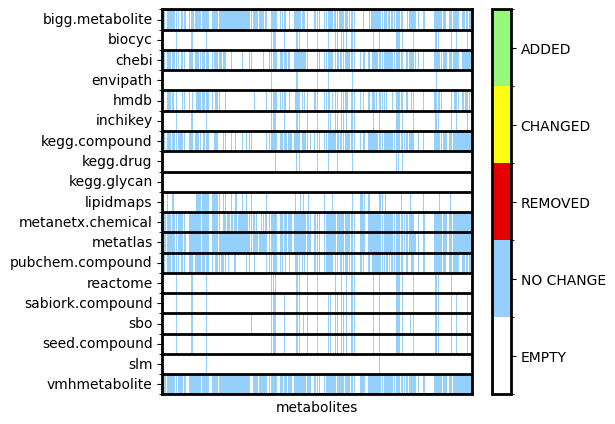

In [10]:
assert (
    len(to_double_check[annotation_type]) == 0
), f"There are still columns with data that need reconcilliation: {to_double_check[annotation_type]}"
df_annotations = model_annotation_dfs[annotation_type]

if compare:
    try:
        df_previous = pd.read_csv(
            f"{ROOT_PATH}{MODEL_PATH}/{annotation_type}.tsv",
            sep="\t",
            index_col=0,
            dtype=str,
        )
    except FileNotFoundError:
        df_previous = pd.DataFrame([], columns=[annotation_type])

    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    df_comparision = compare_tables(
        df_previous.set_index(annotation_type),
        df_annotations.set_index(annotation_type),
    )
    ax = visualize_comparison(df_comparision)

if display_nunique:
    for col in df_annotations.columns:
        df = (
            df_annotations[col]
            .apply(lambda x: split_string(x))
            .explode(col)
            .drop_duplicates()
        )
        print(f"{df.name}: {df.nunique()}")


if overwrite:
    df_annotations.to_csv(f"{ROOT_PATH}{MODEL_PATH}/{annotation_type}.tsv", sep="\t")
else:
    df_annotations.to_csv(f"{ROOT_PATH}{INTERIM_PATH}/{annotation_type}.tsv", sep="\t")
df_annotations

### Genes

In [11]:
annotation_type = "genes"
databases = [
    HUMANGEM_DB_TAG,
    UNIPROT_DB_TAG,
    MIM_DB_TAG,
    TCDB_DB_TAG,
    DRUGBANK_DB_TAG,
    DRUGCENTRAL_DB_TAG,
    CDCDB_DB_TAG,
    "References",
]
df_annotations_all = pd.read_csv(
    f"{ROOT_PATH}{MODEL_PATH}/{annotation_type}.tsv",
    sep="\t",
    index_col=0,
    dtype=str,
)
df_annotations_all = df_annotations_all.set_index(annotation_type)
df_annotations_all = df_annotations_all.rename(
    {c: f"{c}_MODEL" for c in df_annotations_all.columns}, axis=1
)

for db_tag in databases:
    df = pd.read_csv(
        f"{annotation_dirpath}/{annotation_type}_{db_tag}.tsv",
        sep="\t",
        index_col=0,
        dtype=str,
    ).set_index(annotation_type)
    df.columns = [f"{c}_{db_tag}" for c in df.columns]
    df_annotations_all = df_annotations_all.merge(
        df,
        left_index=True,
        right_index=True,
        how="left",
    )

# Keep database tags on duplicate columns for reconcilliation, remove for unique columns
unique_columns = set([name.rsplit("_", 1)[0] for name in df_annotations_all.columns])
to_double_check[annotation_type] = {
    unique: [
        name for name in df_annotations_all.columns if name.rsplit("_", 1)[0] == unique
    ]
    for unique in sorted(unique_columns)
}
unique_mapping = {
    to_double_check[annotation_type].pop(unique).pop(): unique
    for unique, dbs in to_double_check[annotation_type].copy().items()
    if len(dbs) == 1
}
print(f"Annotation columns to reconcile: {to_double_check[annotation_type]}")
df_annotations_all

Annotation columns to reconcile: {'bgee.gene': ['bgee.gene_MODEL', 'bgee.gene_UniProt'], 'biocyc': ['biocyc_MODEL', 'biocyc_UniProt'], 'biogrid': ['biogrid_MODEL', 'biogrid_UniProt'], 'bmrb': ['bmrb_MODEL', 'bmrb_UniProt'], 'brenda': ['brenda_MODEL', 'brenda_UniProt'], 'cazy': ['cazy_MODEL', 'cazy_UniProt'], 'ccds': ['ccds_MODEL', 'ccds_UniProt'], 'cdd': ['cdd_MODEL', 'cdd_UniProt'], 'chembl.target': ['chembl.target_MODEL', 'chembl.target_UniProt'], 'complexportal': ['complexportal_MODEL', 'complexportal_UniProt'], 'dbsnp': ['dbsnp_MODEL', 'dbsnp_UniProt', 'dbsnp_DrugBank'], 'dip': ['dip_MODEL', 'dip_UniProt'], 'disprot': ['disprot_MODEL', 'disprot_UniProt'], 'drugbank': ['drugbank_MODEL', 'drugbank_UniProt', 'drugbank_DrugBank', 'drugbank_CDCDB'], 'drugcentral': ['drugcentral_MODEL', 'drugcentral_DrugCentral'], 'ec-code': ['ec-code_MODEL', 'ec-code_UniProt'], 'eggnog': ['eggnog_MODEL', 'eggnog_UniProt'], 'ena.embl': ['ena.embl_MODEL', 'ena.embl_UniProt'], 'ensembl': ['ensembl_MODEL', 

,hprd_MODEL,ncbigi_MODEL,sbo_MODEL,uniprot_MODEL,uniprot.isoform_MODEL,uniprot.chain_MODEL,refseq_MODEL,ncbigene_MODEL,hgnc.symbol_MODEL,ccds_MODEL,...,pfam_DrugBank,hgnc.symbol_DrugBank,dbsnp_DrugBank,smpdb_DrugBank,uniprot_DrugCentral,hgnc.symbol_DrugCentral,drugcentral_DrugCentral,drugbank_CDCDB,pubchem.compound_CDCDB,references_References
genes,,,,,,,,,,,,,,,,,,,,,
A4GALT,NaN,NaN,NaN,Q9NPC4,NaN,PRO_0000080578,NP_001304967.1;NP_059132.1;XP_005261701.1;XP_0...,53947,A4GALT,CCDS14041.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pubmed:12888565;pubmed:29662110;pubmed:34360826
AARS1,NaN,NaN,NaN,P49588,NaN,PRO_0000075281,NP_001596.2,16,AARS1,CCDS32474.1,...,PF01411;PF02272;PF07973,AARS,NaN,SMP0000055;SMP0000313;SMP0000350;SMP0000352,NaN,NaN,NaN,DB00160,NaN,pubmed:19421340;pubmed:35976696
AASDHPPT,NaN,NaN,NaN,Q9NRN7,NaN,PRO_0000175736,NP_056238.2,60496,AASDHPPT,CCDS31664.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ABCA1,NaN,NaN,NaN,O95477,NaN,PRO_0000093288,NP_005493.2,19,ABCA1,CCDS6762.1,...,PF00005,ABCA1,NaN,NaN,O95477,ABCA1,2269,DB00163;DB00171;DB00675;DB01016;DB01599;DB11635,14985;2733525;2733526;3488;4912;5957,pubmed:27239515;pubmed:32907987
ABCA7,NaN,NaN,NaN,Q8IZY2,NaN,PRO_0000250674,NP_061985.2;XP_011525930.1,10347,ABCA7,CCDS12055.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pubmed:12917409;pubmed:15520449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YARS1,NaN,NaN,NaN,P54577,NaN,PRO_0000423285;PRO_0000055673,NP_003671.1,8565,YARS1,CCDS368.1,...,PF00579;PF01588,YARS,NaN,SMP0000008;SMP0000206;SMP0000369;SMP0000370,P54577,YARS,3064,DB00135;DB01766;DB02709;DB03978;DB07205;DB0837...,445154;6057,pubmed:19421340;pubmed:35976696
ZDHHC2,NaN,NaN,NaN,Q9UIJ5,NaN,PRO_0000212859,NP_057437.1,51201,ZDHHC2,CCDS47810.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZDHHC20,NaN,NaN,NaN,Q5W0Z9,NaN,PRO_0000212906,NP_001273567.1;NP_001316988.1;NP_694983.2,253832,ZDHHC20,CCDS45017.1;CCDS81758.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Reconcile cross-referenced from multiple sources
These columns had multiple mappings and need to be reconciled.

Currently, overwrites with one database and will preserve previous model annotations if nothing exists for a field.

In [12]:
reconcilliation = {
    # Overwrite with UniProt
    "uniprot": UNIPROT_DB_TAG,
    "uniprot.isoform": UNIPROT_DB_TAG,
    "uniprot.chain": UNIPROT_DB_TAG,
    "refseq": UNIPROT_DB_TAG,
    "ncbigene": UNIPROT_DB_TAG,
    "hgnc.symbol": UNIPROT_DB_TAG,
    "ccds": UNIPROT_DB_TAG,
    "dbsnp": UNIPROT_DB_TAG,
    "ec-code": UNIPROT_DB_TAG,
    "pdb": UNIPROT_DB_TAG,
    "pfam": UNIPROT_DB_TAG,
    "go": UNIPROT_DB_TAG,
    "pharmgkb.gene": UNIPROT_DB_TAG,
    "taxonomy": UNIPROT_DB_TAG,
    "smr": UNIPROT_DB_TAG,
    "iuphar.receptor": UNIPROT_DB_TAG,
    "hgnc": UNIPROT_DB_TAG,
    # Overwrite with DrugCentral
    "drugcentral": DRUGCENTRAL_DB_TAG,
    # Overwrite with DrugBank
    "drugbank": DRUGBANK_DB_TAG,
    "smpdb": DRUGBANK_DB_TAG,
    # Overwritewith TCDB
    "tcdb": TCDB_DB_TAG,
    # Overwrite with MetAtlas
    "ensembl": HUMANGEM_DB_TAG,
    # Overwrite with MIM
    "mgi": MIM_DB_TAG,
    "mim": MIM_DB_TAG,
    # Overwrite with info from CDCDB
    "pubchem.compound": CDCDB_DB_TAG,
    # Non-miriam fields
    "references": "References",
    # To double check eventually for formatting within model
    "string": "UniProt",
    "hogenom": "UniProt",
    "genewiki": "UniProt",
    "prints": "UniProt",
    "supfam": "UniProt",
    "bindingdb": "UniProt",
    "gxa": "UniProt",
    "sasbdb": "UniProt",
    "complexportal": "UniProt",
    "merops": "UniProt",
    "allergome": "UniProt",
    "ideal": "UniProt",
    "cazy": "UniProt",
    "bgee.gene": "UniProt",
    "panther.family": "UniProt",
    "ena.embl": "UniProt",
    "nextprot": "UniProt",
    "reactome": "UniProt",
    "pirsf": "UniProt",
    "smart": "UniProt",
    "dip": "UniProt",
    "genetree": "UniProt",
    "rhea": "UniProt",
    "pathwaycommons": "UniProt",
    "depod": "UniProt",
    "kegg.genes": "UniProt",
    "disprot": "UniProt",
    "massive": "UniProt",
    "peptideatlas": "UniProt",
    "elm": "UniProt",
    "maxqb": "UniProt",
    "brenda": "UniProt",
    "hamap": "UniProt",
    "slm": "UniProt",
    "phosphosite.protein": "UniProt",
    "cdd": "UniProt",
    "pride": "UniProt",
    "ctd": "UniProt",
    "phylomedb": "UniProt",
    "paxdb.protein": "UniProt",
    "proteomicsdb.protein": "UniProt",
    "epd": "UniProt",
    "hpa": "UniProt",
    "interpro": "UniProt",
    "mint": "UniProt",
    "signor": "UniProt",
    "orthodb": "UniProt",
    "biocyc": "UniProt",
    "chembl.target": "UniProt",
    "orphanet": "UniProt",
    "genecards": "UniProt",
    "biogrid": "UniProt",
    "uniparc": "UniProt",
    "intact": "UniProt",
    "prosite": "UniProt",
    "corum": "UniProt",
    "bmrb": "UniProt",
    "peroxibase": "UniProt",
    "treefam": "UniProt",
    "oma.grp": "UniProt",
    "eggnog": "UniProt",
}

df_annotations = df_annotations_all.copy()
for key, chosen_col in reconcilliation.items():
    if key not in to_double_check[annotation_type]:
        continue
    df_base_column = df_annotations_all.loc[:, f"{key}_{chosen_col}"].copy()
    df_base_column.name = key
    df_columns = df_annotations_all.loc[:, to_double_check[annotation_type][key]]
    for idx, row in df_columns.iterrows():
        if preserve_model_previous:
            # Preserve old ID to prevent loss of ID
            try:
                if not row.isna()[f"{key}_MODEL"] and row.isna()[f"{key}_{chosen_col}"]:
                    df_base_column[idx] = row[f"{key}_MODEL"]
            except KeyError as e:
                pass

    df_annotations[key] = df_base_column
    df_annotations = df_annotations.drop(to_double_check[annotation_type][key], axis=1)
    to_double_check[annotation_type].pop(key)

# Overwrite
df_annotations = df_annotations.rename(unique_mapping, axis=1)
df_annotations = df_annotations.reset_index(drop=False)
model_annotation_dfs[annotation_type] = df_annotations
df_annotations

,genes,hprd,ncbigi,sbo,uniprot,uniprot.isoform,uniprot.chain,refseq,ncbigene,hgnc.symbol,...,orphanet,genecards,biogrid,uniparc,prosite,bmrb,peroxibase,treefam,oma.grp,eggnog
0,A4GALT,NaN,NaN,NaN,Q9NPC4,NaN,PRO_0000080578,NP_001304967.1;NP_059132.1;XP_005261701.1;XP_0...,53947,A4GALT,...,NaN,A4GALT,119825,UPI000003FF92,NaN,NaN,NaN,TF324053,HKFIELC,KOG1928
1,AARS1,NaN,NaN,NaN,P49588,NaN,PRO_0000075281,NP_001596.2,16,AARS1,...,228174;442835;33364,AARS1,106534,UPI0000169F0B,PS50860,NaN,NaN,TF300737,YHHTMFE,KOG0188
2,AASDHPPT,NaN,NaN,NaN,Q9NRN7,NaN,PRO_0000175736,NP_056238.2,60496,AASDHPPT,...,NaN,AASDHPPT,121927,UPI0000034CAD,NaN,NaN,NaN,TF313753,IPWSEIR,KOG0945
3,ABCA1,NaN,NaN,NaN,O95477,NaN,PRO_0000093288,NP_005493.2,19,ABCA1,...,425;31150,ABCA1,106537,UPI000013E441,PS00211;PS50893,NaN,NaN,TF105191,TSISMML,KOG0059
4,ABCA7,NaN,NaN,NaN,Q8IZY2,NaN,PRO_0000250674,NP_061985.2;XP_011525930.1,10347,ABCA7,...,1020;238616,ABCA7,115629,UPI000013D3A4,PS00211;PS50893,NaN,NaN,TF105191,AQEPLHS,KOG0059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651,YARS1,NaN,NaN,NaN,P54577,NaN,PRO_0000423285;PRO_0000055673,NP_003671.1,8565,YARS1,...,100045,YARS1,114134,UPI0000136762,PS50886,NaN,NaN,TF300898,ERPEKFG,KOG2144;KOG2241
652,ZDHHC2,NaN,NaN,NaN,Q9UIJ5,NaN,PRO_0000212859,NP_057437.1,51201,ZDHHC2,...,NaN,ZDHHC2,119374,UPI000004A02F,PS50216,NaN,NaN,TF316044,WVNNCIN,KOG1315
653,ZDHHC20,NaN,NaN,NaN,Q5W0Z9,NaN,PRO_0000212906,NP_001273567.1;NP_001316988.1;NP_694983.2,253832,ZDHHC20,...,NaN,ZDHHC20,128991,UPI000045881B,PS50216,NaN,NaN,TF316044,ELCVCEY,KOG1315
654,ZDHHC3,NaN,NaN,NaN,Q9NYG2,NaN,PRO_0000422064,NP_001128651.1;NP_057682.1;XP_016862055.1;XP_0...,51304,ZDHHC3,...,NaN,ZDHHC3,119455,UPI000002B749,PS50216,NaN,NaN,TF319798,NaN,KOG1311


#### Save annotations

genes: 656
hprd: 91
ncbigi: 108
sbo: 1
uniprot: 656
uniprot.isoform: 171
uniprot.chain: 689
refseq: 2002
ncbigene: 660
hgnc.symbol: 657
ccds: 1153
dbsnp: 4308
ec-code: 487
pdb: 9438
pfam: 617
go: 5242
pharmgkb.gene: 652
taxonomy: 1
smr: 640
iuphar.receptor: 152
hgnc: 657
drugcentral: 649
drugbank: 2066
smpdb: 605
tcdb: 129
ensembl: 470
mgi: 688
mim: 1142
pubchem.compound: 1152
references: 603
hogenom: 478
genewiki: 492
prints: 181
supfam: 282
sasbdb: 29
complexportal: 149
merops: 33
ideal: 21
cazy: 18
bgee.gene: 655
panther.family: 1111
ena.embl: 7052
nextprot: 656
reactome: 895
pirsf: 132
smart: 147
dip: 183
genetree: 598
kegg.genes: 637
disprot: 34
brenda: 375
hamap: 86
cdd: 527
proteomicsdb.protein: 1425
hpa: 655
interpro: 1652
orthodb: 468
biocyc: 247
chembl.target: 439
orphanet: 460
genecards: 657
biogrid: 658
uniparc: 656
prosite: 357
bmrb: 68
peroxibase: 11
treefam: 501
oma.grp: 624
eggnog: 499


,genes,hprd,ncbigi,sbo,uniprot,uniprot.isoform,uniprot.chain,refseq,ncbigene,hgnc.symbol,...,orphanet,genecards,biogrid,uniparc,prosite,bmrb,peroxibase,treefam,oma.grp,eggnog
0,A4GALT,NaN,NaN,NaN,Q9NPC4,NaN,PRO_0000080578,NP_001304967.1;NP_059132.1;XP_005261701.1;XP_0...,53947,A4GALT,...,NaN,A4GALT,119825,UPI000003FF92,NaN,NaN,NaN,TF324053,HKFIELC,KOG1928
1,AARS1,NaN,NaN,NaN,P49588,NaN,PRO_0000075281,NP_001596.2,16,AARS1,...,228174;442835;33364,AARS1,106534,UPI0000169F0B,PS50860,NaN,NaN,TF300737,YHHTMFE,KOG0188
2,AASDHPPT,NaN,NaN,NaN,Q9NRN7,NaN,PRO_0000175736,NP_056238.2,60496,AASDHPPT,...,NaN,AASDHPPT,121927,UPI0000034CAD,NaN,NaN,NaN,TF313753,IPWSEIR,KOG0945
3,ABCA1,NaN,NaN,NaN,O95477,NaN,PRO_0000093288,NP_005493.2,19,ABCA1,...,425;31150,ABCA1,106537,UPI000013E441,PS00211;PS50893,NaN,NaN,TF105191,TSISMML,KOG0059
4,ABCA7,NaN,NaN,NaN,Q8IZY2,NaN,PRO_0000250674,NP_061985.2;XP_011525930.1,10347,ABCA7,...,1020;238616,ABCA7,115629,UPI000013D3A4,PS00211;PS50893,NaN,NaN,TF105191,AQEPLHS,KOG0059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651,YARS1,NaN,NaN,NaN,P54577,NaN,PRO_0000423285;PRO_0000055673,NP_003671.1,8565,YARS1,...,100045,YARS1,114134,UPI0000136762,PS50886,NaN,NaN,TF300898,ERPEKFG,KOG2144;KOG2241
652,ZDHHC2,NaN,NaN,NaN,Q9UIJ5,NaN,PRO_0000212859,NP_057437.1,51201,ZDHHC2,...,NaN,ZDHHC2,119374,UPI000004A02F,PS50216,NaN,NaN,TF316044,WVNNCIN,KOG1315
653,ZDHHC20,NaN,NaN,NaN,Q5W0Z9,NaN,PRO_0000212906,NP_001273567.1;NP_001316988.1;NP_694983.2,253832,ZDHHC20,...,NaN,ZDHHC20,128991,UPI000045881B,PS50216,NaN,NaN,TF316044,ELCVCEY,KOG1315
654,ZDHHC3,NaN,NaN,NaN,Q9NYG2,NaN,PRO_0000422064,NP_001128651.1;NP_057682.1;XP_016862055.1;XP_0...,51304,ZDHHC3,...,NaN,ZDHHC3,119455,UPI000002B749,PS50216,NaN,NaN,TF319798,NaN,KOG1311


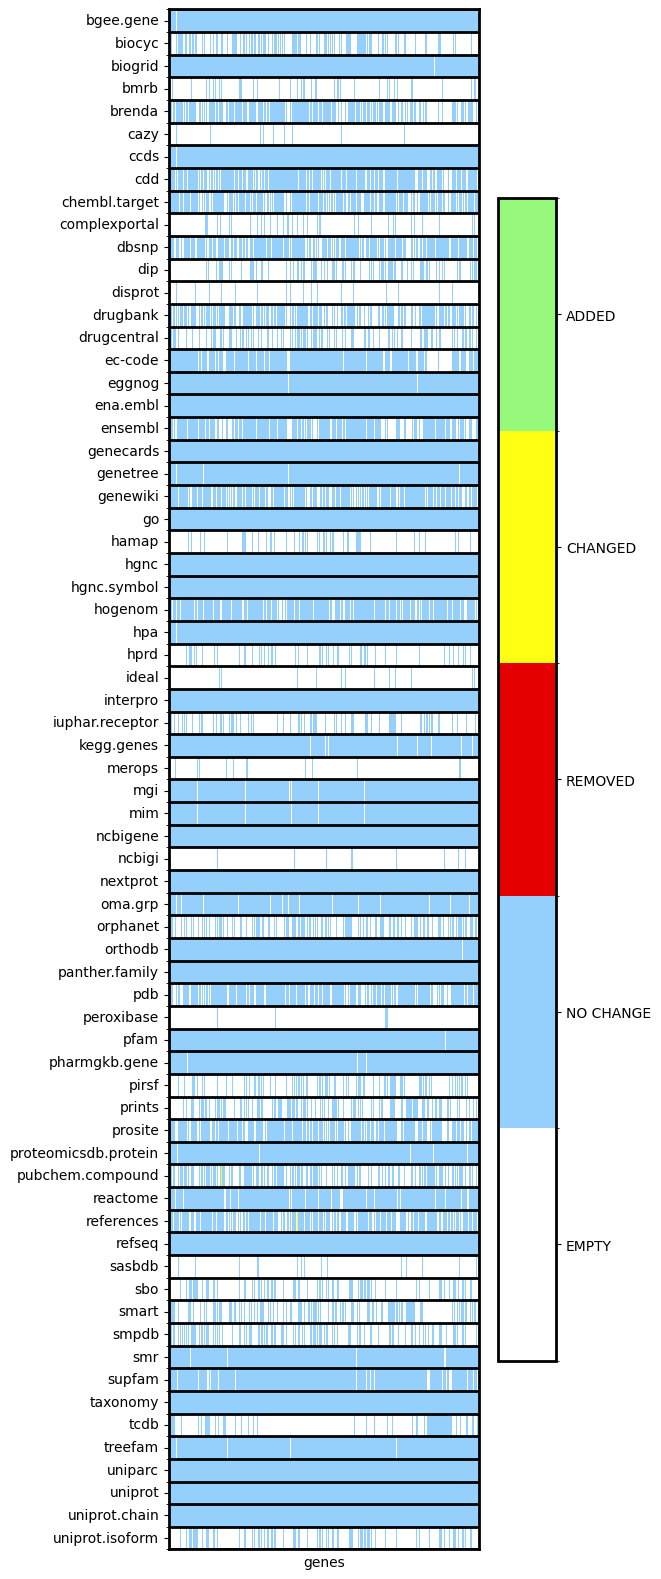

In [13]:
assert (
    len(to_double_check[annotation_type]) == 0
), f"There are still columns with data that need reconcilliation: {to_double_check[annotation_type]}"
df_annotations = model_annotation_dfs[annotation_type]

if compare:
    try:
        df_previous = pd.read_csv(
            f"{ROOT_PATH}{MODEL_PATH}/{annotation_type}.tsv",
            sep="\t",
            index_col=0,
            dtype=str,
        )
    except FileNotFoundError:
        df_previous = pd.DataFrame([], columns=[annotation_type])

    fig, ax = plt.subplots(1, 1, figsize=(5, 20))
    df_comparision = compare_tables(
        df_previous.set_index(annotation_type),
        df_annotations.set_index(annotation_type),
    )
    ax = visualize_comparison(df_comparision)

if display_nunique:
    for col in df_annotations.columns:
        df = (
            df_annotations[col]
            .apply(lambda x: split_string(x))
            .explode(col)
            .drop_duplicates()
        )
        print(f"{df.name}: {df.nunique()}")

if overwrite:
    df_annotations.to_csv(f"{ROOT_PATH}{MODEL_PATH}/{annotation_type}.tsv", sep="\t")
else:
    df_annotations.to_csv(f"{ROOT_PATH}{INTERIM_PATH}/{annotation_type}.tsv", sep="\t")
df_annotations